In [1]:
!uv pip install -q --system numba-cuda==0.4.0

In [2]:
import numba.cuda as cuda
from numba import config
import numba
config.CUDA_ENABLE_PYNVJITLINK = 1
import matplotlib.pyplot as plt
import numpy as np
import time
from sys import argv
import math

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


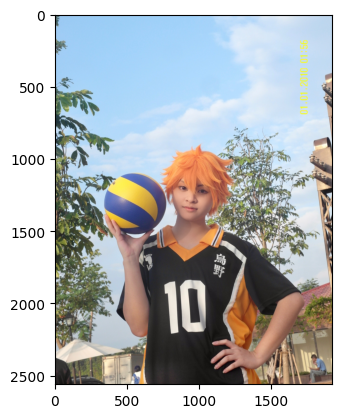

In [4]:
img_path = "/content/drive/MyDrive/Ảnh/Fes/Yosakoi 14 5 22/IMG_8500.JPG"
img = plt.imread(img_path)
plt.imshow(img)

Grayscale image binarization

In [5]:
@cuda.jit
def grayscale2dbin(value, threshold):
  return 1 if value > threshold else 0

@cuda.jit
def grayscale2d(src, dst):
# where are we in the input?
  tidx = cuda.threadIdx.x + cuda.blockIdx.x * cuda.blockDim.x
  tidy = cuda.threadIdx.y + cuda.blockIdx.y * cuda.blockDim.y

  if tidx < src.shape[0] and tidy < src.shape[1]:
    g = ((src[tidx, tidy, 0] + src[tidx, tidy, 1] + src[tidx, tidy, 2]) / 3)
    dst[tidx, tidy, 0] = g
    dst[tidx, tidy, 1] = g
    dst[tidx, tidy, 2] = g

    dst[tidx, tidy, 0] = grayscale2dbin(g, 128)
    dst[tidx, tidy, 1] = grayscale2dbin(g, 128)
    dst[tidx, tidy, 2] = grayscale2dbin(g, 128)




(2560, 1920, 3)
<class 'numba.cuda.cudadrv.devicearray.DeviceNDArray'>
0.00030517578125


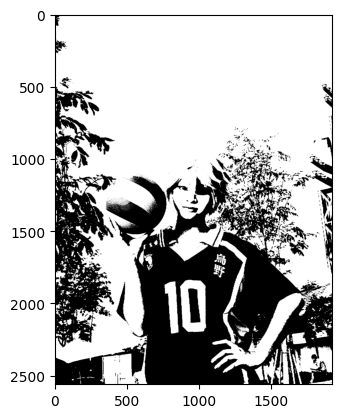

In [8]:

img_cuda = cuda.to_device(img)
print(img_cuda.shape)
print(type(img_cuda))
block_size = (32, 8)
grid_size = (math.ceil(img.shape[0] / block_size[0]), math.ceil(img.shape[1] / block_size[1]))

gray_img_cuda =  cuda.device_array((img.shape[0], img.shape[1], 1))
start = time.time()
grayscale2d[grid_size, block_size](img_cuda, gray_img_cuda)
end = time.time()
print(end-start)
gray_img = gray_img_cuda.copy_to_host()
# gray_img = gray_img_host.reshape(img.shape[0], img.shape[1], 1)

plt.imshow(gray_img, cmap="gray")

Brightness Control

In [27]:
@cuda.jit
def brightness_control(value, amount):
  if value + amount >= 255:
    return 255
  if value - amount <=0:
    return 0
  return value + amount

@cuda.jit
def brightness(src, dst, amount):
  tidx = cuda.threadIdx.x + cuda.blockIdx.x * cuda.blockDim.x
  tidy = cuda.threadIdx.y + cuda.blockIdx.y * cuda.blockDim.y

  if tidx < src.shape[0] and tidy < src.shape[1]:
    dst[tidx, tidy, 0] = brightness_control(src[tidx, tidy, 0], amount)
    dst[tidx, tidy, 1] = brightness_control(src[tidx, tidy, 1], amount)
    dst[tidx, tidy, 2] = brightness_control(src[tidx, tidy, 2], amount)



(2560, 1920, 3)
<class 'numba.cuda.cudadrv.devicearray.DeviceNDArray'>
0.0002856254577636719


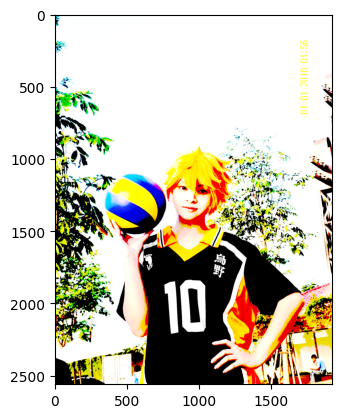

In [32]:
img_cuda = cuda.to_device(img)
print(img_cuda.shape)
print(type(img_cuda))
block_size = (32, 8)
grid_size = (math.ceil(img.shape[0] / block_size[0]), math.ceil(img.shape[1] / block_size[1]))

amount = 100
gray_img_cuda =  cuda.device_array((img.shape[0], img.shape[1], 3), dtype = np.uint8)
start = time.time()
brightness[grid_size, block_size](img_cuda, gray_img_cuda, amount)
end = time.time()
print(end-start)
converted_img = gray_img_cuda.copy_to_host()
# gray_img = gray_img_host.reshape(img.shape[0], img.shape[1], 1)

plt.imshow(converted_img)

Blend Images

In [35]:
@cuda.jit
def blend_pixel(val1, val2, c):
  return val1*c + val2*(1-c)

@cuda.jit
def blend_images(src1, src2, dst, c):
  tidx = cuda.threadIdx.x + cuda.blockIdx.x * cuda.blockDim.x
  tidy = cuda.threadIdx.y + cuda.blockIdx.y * cuda.blockDim.y

  dst[tidx, tidy, 0] = blend_pixel(src1[tidx, tidy, 0], src2[tidx, tidy, 0], c)
  dst[tidx, tidy, 1] = blend_pixel(src1[tidx, tidy, 1], src2[tidx, tidy, 1], c)
  dst[tidx, tidy, 2] = blend_pixel(src1[tidx, tidy, 2], src2[tidx, tidy, 2], c)


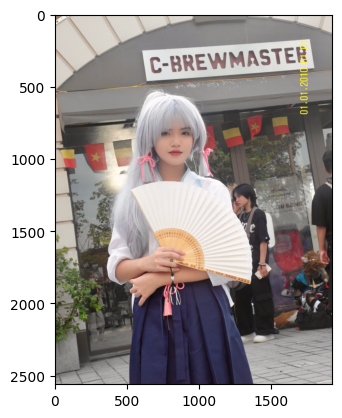

In [39]:
img2_path = "/content/drive/MyDrive/Ảnh/Fes/Yosakoi 14 5 22/IMG_8497.JPG"
img2 = plt.imread(img2_path)
plt.imshow(img2)

(2560, 1920, 3)
<class 'numba.cuda.cudadrv.devicearray.DeviceNDArray'>
0.0004031658172607422


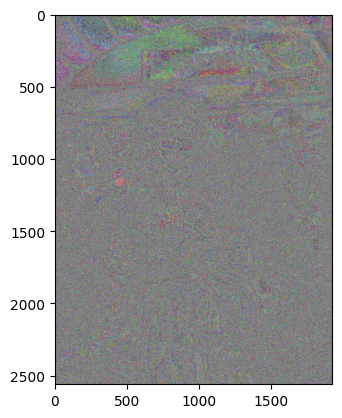

In [40]:


img_cuda2 =cuda.to_device(img2)
img_cuda = cuda.to_device(img)
print(img_cuda.shape)
print(type(img_cuda))
block_size = (8, 8)
grid_size = (math.ceil(img.shape[0] / block_size[0]), math.ceil(img.shape[1] / block_size[1]))
gray_img_cuda =  cuda.device_array((img.shape[0], img.shape[1], 3), dtype = np.uint8)
start = time.time()
blend_images[grid_size, block_size](img_cuda, img_cuda2, gray_img_cuda, amount)
end = time.time()
print(end-start)
converted_img = gray_img_cuda.copy_to_host()
# gray_img = gray_img_host.reshape(img.shape[0], img.shape[1], 1)

plt.imshow(converted_img)